In [2]:
import gymnasium as gym
import numpy as np
import random
from gym.wrappers import TimeLimit
import torch.optim as optim
import copy
import gym
env = gym.make('CartPole-v1')
env2 = gym.make('MountainCar-v0')
from gym.spaces import Discrete

# Assuming the number of discrete actions is 3
action_space = Discrete(3)

FOR TA: THIS FILES CONTAIN ALL THE RESULT FOR Q3 (ACTOR CRITIC + REINFORCE) + SOME Q1 (PART OF THE MOUNTAIN CAR RESULT FOR EXPECTED SARSA)

In [3]:
def bin_divider(observation, bins, min, max):
  if (observation < min):
    return 0
  if (observation > max):
    return bins-1
  return int((observation-min)/((max-min)/bins))

def policy_encoding(state, action):
    encoded = np.zeros(81)
    encoded[80] = 1
    if action == 0:
      left_right = 0
    else:
      left_right = 40 
    action_0_index = bin_divider(state[0], 10, -4.8, 4.8)+left_right
    action_1_index = bin_divider(state[1], 10, -10, 10)+10+left_right
    action_2_index = bin_divider(state[2], 10, -0.42, 0.42)+20+left_right
    action_3_index = bin_divider(state[3], 10, -10, 10)+30+left_right
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    encoded[action_2_index] = 1
    encoded[action_3_index] = 1
    return encoded

def policy_encoding_mountcar(state, action, bin = 10):
    encoded = np.zeros(61)
    encoded[60] = 1
    if action == 0:
      left_right = 0
    elif action == 1:
      left_right = 20
    else:
      left_right = 40
    action_0_index = bin_divider(state[0], bin, -1.2, 0.6)+left_right
    action_1_index = bin_divider(state[1], bin, -0.07, 0.07)+ 10 +left_right
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    return encoded
  
def tile_encoding_mountcar(state, bin=10):
    encoded = np.zeros(21)
    encoded[20] = 1
    action_0_index = bin_divider(state[0], bin, -1.2, 0.6)
    action_1_index = bin_divider(state[1], bin, -0.07, 0.07)+ 10 
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    return encoded
  
def tile_encoding(state):
    encoded = np.zeros(41)
    encoded[40] = 1
    action_0_index = bin_divider(state[0], 10, -4.8, 4.8)
    action_1_index = bin_divider(state[1], 10, -10,10)+10
    action_2_index = bin_divider(state[2], 10, -0.42, 0.42)
    action_3_index = bin_divider(state[3], 10, -10, 10)+30
    encoded[action_0_index] = 1
    encoded[action_1_index] = 1
    encoded[action_2_index] = 1
    encoded[action_3_index] = 1
    return encoded


def softmax(state, theta, TEMP):
  if TEMP < 1:
    TEMP = 1
  probability_picking0 = np.exp(np.dot(theta, policy_encoding(state, 0))/TEMP)
  probability_picking1 = np.exp(np.dot(theta, policy_encoding(state, 1))/TEMP)
  sum_s = probability_picking0 + probability_picking1 + 1e-10
  probabilities = [probability_picking0/sum_s,probability_picking1/sum_s]
  action = random.choices([0,1],weights=probabilities,k=1)[0]
  return action, probabilities

def softmax_overflow(state, theta, TEMP):
    if TEMP < 1:
        TEMP = 1

    policy_0 = policy_encoding(state, 0)
    policy_1 = policy_encoding(state, 1)
    dot_0 = np.dot(theta, policy_0) / TEMP
    dot_1 = np.dot(theta, policy_1) / TEMP

    max_dot = max(dot_0, dot_1)
    exp_0 = np.exp(dot_0 - max_dot)
    exp_1 = np.exp(dot_1 - max_dot)
    
    sum_exp = exp_0 + exp_1 + 1e-10  
    probabilities = [exp_0 / sum_exp, exp_1 / sum_exp]
    
    action = random.choices([0, 1], weights=probabilities, k=1)[0]
    return action, probabilities
  

def softmax_overflow_mountcar(state, theta, TEMP):
    if TEMP < 1:
        TEMP = 1
    policy_0 = policy_encoding_mountcar(state, 0)
    policy_1 = policy_encoding_mountcar(state, 1)
    policy_2 = policy_encoding_mountcar(state, 2)
    dot_0 = np.dot(theta, policy_0) / TEMP
    dot_1 = np.dot(theta, policy_1) / TEMP
    dot_2 = np.dot(theta, policy_2) / TEMP
    max_dot = max(dot_0, dot_1, dot_2)
    exp_0 = np.exp(dot_0 - max_dot)
    exp_1 = np.exp(dot_1 - max_dot)
    exp_2 = np.exp(dot_2 - max_dot)
    sum_exp = exp_0 + exp_1 + exp_2 + 1e-10  
    probabilities = [exp_0 / sum_exp, exp_1 / sum_exp, exp_2 / sum_exp]
    action = random.choices([0, 1, 2], weights=probabilities, k=1)[0]
    return action, probabilities


In [113]:
def reinforce_Mountain_Car(alpha, gamma, temp, maximum_step=250, bin=10, change_temp=False):
    gym.envs.register(
    id='MountainCarMyEasyVersion-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=maximum_step
)
    env = gym.make('MountainCarMyEasyVersion-v0')
    returns = np.zeros((1, 1000))
    for run in range(1):
        alpha=alpha
        theta = np.random.uniform(-0.001,0.001,(1,61)) # policy parameters
        gamma=gamma
        TEMP = temp
        print("run -- ", run)
        action_space = env.action_space
        for e in range(1000):
            observation, _ = env.reset(seed=run)
            truncated = False
            terminated = False
            I = 1
            reward_per_term = []
            observation_per_term = []
            probability_per_term = []
            action_per_term = []
            if TEMP < 1:
                TEMP = 1
            while not terminated and not truncated:
                action, prob = softmax_overflow_mountcar(observation, theta, TEMP)
                next_observation, reward, terminated, truncated, info = env.step(action)
                reward_per_term.append(reward)
                action_per_term.append(action)
                probability_per_term.append(prob)
                observation_per_term.append(observation)
                observation = next_observation
                returns[run, e] -= 1
            sum_reward = 0
            for i in reward_per_term:
                sum_reward += i
            curr_total = 0
            GT_for_each_obs = []
            for i in range(len(reward_per_term)):
                GT_for_each_obs.append(sum_reward - curr_total)
                curr_total += reward_per_term[i]
            for i in range(len(observation_per_term)):
                observation = observation_per_term[i]
                prob = probability_per_term[i]
                action = action_per_term[i]
                left_theta = policy_encoding_mountcar(observation, 0)
                right_theta = policy_encoding_mountcar(observation, 1)
                mid_theta = policy_encoding_mountcar(observation, 2)
                sum_of_action = prob[0]*left_theta + prob[1]*right_theta + prob[2]*mid_theta
                gradient = 1/TEMP*policy_encoding_mountcar(observation, action) - sum_of_action
                theta += alpha*I*(GT_for_each_obs[i])*gradient
            #if e%200==199:
                #print(returns[run, e] + maximum_step)
            if change_temp:
               TEMP*=0.99
    returns += maximum_step
    return returns
#return1
#return2
#return3
#return1 = reinforce_Mountain_Car(1/4, 0.99, 5000, maximum_step=15000, bin=10, change_temp=True)
#return3 = reinforce_Mountain_Car(1/16, 0.99, 5000, maximum_step=15000, bin=10, change_temp=True)
return4 = reinforce_Mountain_Car(1/4, 0.99, 10, maximum_step=15000, bin=10, change_temp=False)
#return6 = reinforce_Mountain_Car(1/16, 0.99, 10, maximum_step=15000, bin=10, change_temp=False)

run --  0


In [64]:
def reinforce(alpha, gamma, temp, bin=10, change_temp=False):
    env = gym.make('CartPole-v1')
    returns = np.zeros((50, 2000))
    for run in range(50):
        alpha=alpha
        theta = np.random.uniform(-0.001,0.001,(1,81)) # policy parameters
        gamma=gamma
        TEMP = temp
        print("run -- ", run)
        action_space = env.action_space
        for e in range(1000):
            observation, _ = env.reset(seed=run)
            truncated = False
            terminated = False
            I = 1
            reward_per_term = []
            gradient_per_term = []
            if TEMP < 1:
                TEMP = 1
            while not terminated and not truncated:
                action, prob = softmax_overflow(observation, theta, TEMP)
                next_observation, reward, terminated, truncated, info = env.step(action)
                left_theta = policy_encoding(observation, 0)
                right_theta = policy_encoding(observation, 1)
                sum_of_action = prob[0]*left_theta + prob[1]*right_theta
                gradient = 1/TEMP*policy_encoding(observation, action) - sum_of_action
                gradient_per_term.append(gradient)
                reward_per_term.append(reward)
                observation = next_observation
                returns[run, e] += 1
            GT_for_each_obs = []
            for i in range(len(reward_per_term)):
                I = 1
                for j in range(i, len(reward_per_term)):
                    rewardw = 0
                    rewardw += I*reward_per_term[j]
                    I = I*gamma
                GT_for_each_obs.append(rewardw)
            I = 1
            for i in range(len(reward_per_term)):
                I = I*gamma
                theta += alpha*I*(GT_for_each_obs[i])*gradient_per_term[i]
            #if e%200==199:
            #    print(returns[run, e])
            if change_temp:
               TEMP*=0.99
    return returns
#FIX TEMPERATUR=1
#BIN = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#WE WILL RUN ONE MOUNTA
#return7 = reinforce(1/4, 0.99, 5000,  bin=10, change_temp=True)
#return8 = reinforce(1/8, 0.99, 5000,  bin=10, change_temp=True)
#return9 = reinforce(1/16, 0.99, 5000,  bin=10, change_temp=True)
#return10 = reinforce(1/4, 0.99, 20,  bin=10, change_temp=False)
#return11 = reinforce(1/8, 0.99, 20,  bin=10, change_temp=False)
#return12 = reinforce(1/16, 0.99,20,  bin=10, change_temp=False)
#return19 = reinforce(1/4, 0.99, 5000,  bin=10, change_temp=True)
#return20 = reinforce(1/8, 0.99, 5000,  bin=10, change_temp=True)
#return21 = reinforce(1/16, 0.99, 5000,  bin=10, change_temp=True)
#return22 = reinforce(1/4, 0.99, 20,  bin=10, change_temp=False)
#return23 = reinforce(1/8, 0.99, 20,  bin=10, change_temp=False)
#return24 = reinforce(1/16, 0.99,20,  bin=10, change_temp=False)

In [65]:
return25 = reinforce(1/4, 0.99, 5000,  bin=10, change_temp=True)
return26 = reinforce(1/8, 0.99, 5000,  bin=10, change_temp=True)
return27 = reinforce(1/16, 0.99, 5000,  bin=10, change_temp=True)

run --  0
run --  1
run --  2
run --  3
run --  4
run --  5
run --  6
run --  7
run --  8
run --  9
run --  10
run --  11
run --  12
run --  13
run --  14
run --  15
run --  16
run --  17
run --  18
run --  19
run --  20
run --  21
run --  22
run --  23
run --  24
run --  25
run --  26
run --  27
run --  28
run --  29
run --  30
run --  31
run --  32
run --  33
run --  34
run --  35
run --  36
run --  37
run --  38
run --  39
run --  40
run --  41
run --  42
run --  43
run --  44
run --  45
run --  46
run --  47
run --  48
run --  49
run --  0
run --  1
run --  2
run --  3
run --  4
run --  5
run --  6
run --  7
run --  8
run --  9
run --  10
run --  11
run --  12
run --  13
run --  14
run --  15
run --  16
run --  17
run --  18
run --  19
run --  20
run --  21
run --  22
run --  23
run --  24
run --  25
run --  26
run --  27
run --  28
run --  29
run --  30
run --  31
run --  32
run --  33
run --  34
run --  35
run --  36
run --  37
run --  38
run --  39
run --  40
run --  41
run --  

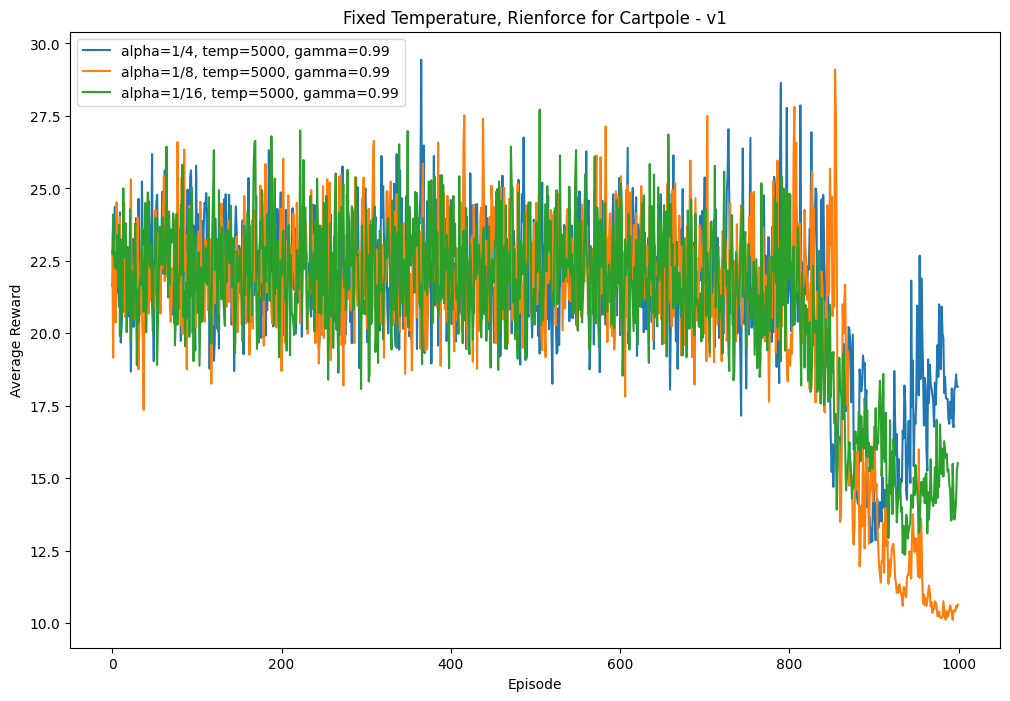

In [117]:
# alpha = 1/8
average_rewards2 = np.mean(return19, axis=0)
average_rewards5 = np.mean(return20, axis=0)
average_rewards8 = np.mean(return21, axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'alpha=1/4, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/8, temp=5000, gamma=0.99')
plt.plot(average_rewards8, label=r'alpha=1/16, temp=5000, gamma=0.99')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Fixed Temperature, Rienforce for Cartpole - v1')
plt.legend()

plt.show()

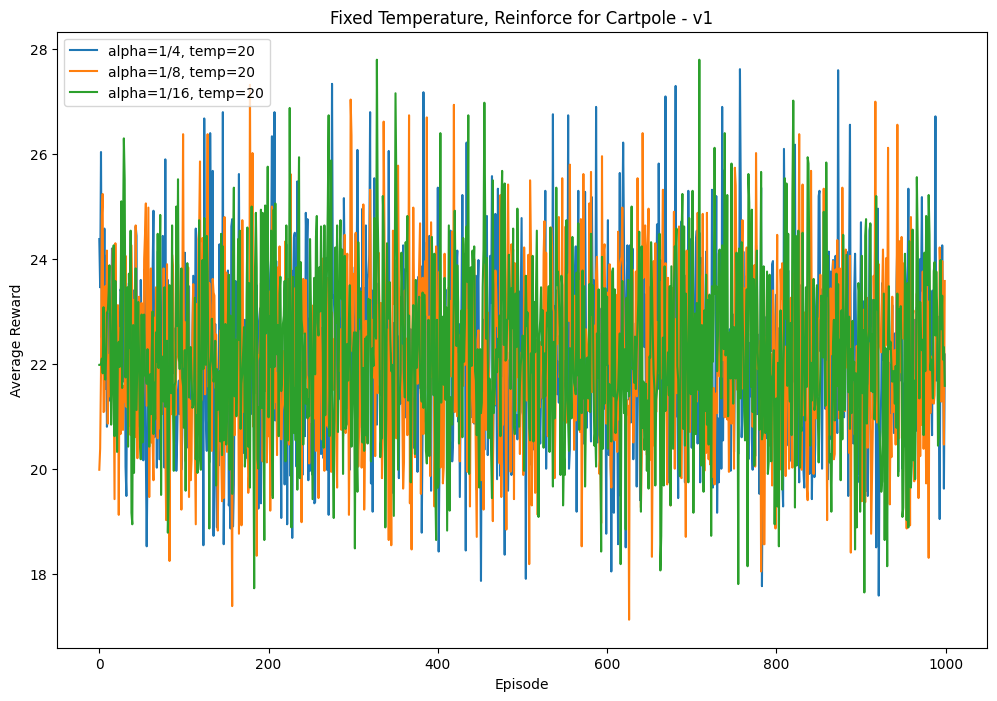

In [116]:
# alpha = 1/8
average_rewards2 = np.mean(return22, axis=0)
average_rewards5 = np.mean(return23, axis=0)
average_rewards8 = np.mean(return24, axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'alpha=1/4, temp=20')
plt.plot(average_rewards5, label=r'alpha=1/8, temp=20')
plt.plot(average_rewards8, label=r'alpha=1/16, temp=20')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Fixed Temperature, Reinforce for Cartpole - v1')
plt.legend()

plt.show()

In [31]:
def actor_critic2(alpha, gamma, temp, envi, change_temp=False):
    #should intilize gamma and alpha
    #automatically recognize number of state
    env = gym.make(envi)
    result = []
    returns = np.zeros((50,1000))

    for run in range(50):
        weights = np.random.uniform(-0.001,0.001,(1,41)) # state-value weights
        theta = np.random.uniform(-0.001,0.001,(1,81)) # policy parameters
        alpha=alpha
        gamma=gamma
        TEMP = temp
        action_space = env.action_space
        print("run--", run)
        for e in range(1000):
            observation, _ = env.reset(seed=run)
            truncated = False
            terminated = False
            I = 1
            #epidode_return = []
            #rewards = 0
            if TEMP < 1:
                TEMP = 1
            while not terminated and not truncated:
                #add temperature to softmax
                action, prob = softmax_overflow(observation, theta, TEMP)
                next_observation, reward, terminated, truncated, info = env.step(action)
                left_theta = policy_encoding(observation, 0)
                right_theta = policy_encoding(observation, 1)
                #formula for calulating gradient
                #rewards += reward
                sum_of_action = np.multiply(prob[0], left_theta) + np.multiply(prob[1], right_theta)
                gradient = 1/TEMP*policy_encoding(observation, action) - sum_of_action
                next_value_state = 0 if terminated else np.dot(weights, tile_encoding(next_observation))
                current_value_state = np.dot(weights, tile_encoding(observation))
                actor_critic_advantage = reward + gamma*next_value_state - current_value_state
                theta += alpha*I*(actor_critic_advantage)*gradient
                weights += alpha*I*(actor_critic_advantage)* tile_encoding(observation)
                observation = next_observation
                I = I*gamma
                returns[run, e] += 1
            #print(TEMP)
            #if e%200==199:
            #    print(returns[run, e])
        #epidode_return = []
        #ask:should we change temperature after each epsidoe or each run
            if change_temp:
              TEMP*=0.99
    return returns
#return13 = actor_critic2(1/16, 0.99, 20, 'CartPole-v1', False)
#return14 = actor_critic2(1/8, 0.99, 20, 'CartPole-v1', False)
#return15 = actor_critic2(1/4, 0.99, 20, 'CartPole-v1', False)
#return16 = actor_critic2(1/16, 0.99, 5000, 'CartPole-v1', True)
#return17 = actor_critic2(1/8, 0.99, 5000, 'CartPole-v1', True)
#return18 = actor_critic2(1/4, 0.99, 5000, 'CartPole-v1', True)

run-- 0


c:\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


run-- 1
run-- 2
run-- 3
run-- 4
run-- 5
run-- 6
run-- 7
run-- 8
run-- 9
run-- 10
run-- 11
run-- 12
run-- 13
run-- 14
run-- 15
run-- 16
run-- 17
run-- 18
run-- 19
run-- 20
run-- 21
run-- 22
run-- 23
run-- 24
run-- 25
run-- 26
run-- 27
run-- 28
run-- 29
run-- 30
run-- 31
run-- 32
run-- 33
run-- 34
run-- 35
run-- 36
run-- 37
run-- 38
run-- 39
run-- 40
run-- 41
run-- 42
run-- 43
run-- 44
run-- 45
run-- 46
run-- 47
run-- 48
run-- 49


In [ ]:
#return13 = actor_critic2(1/16, 0.99, 20, 'CartPole-v1', False)
#return14 = actor_critic2(1/8, 0.99, 20, 'CartPole-v1', False)
#return15 = actor_critic2(1/4, 0.99, 20, 'CartPole-v1', False)

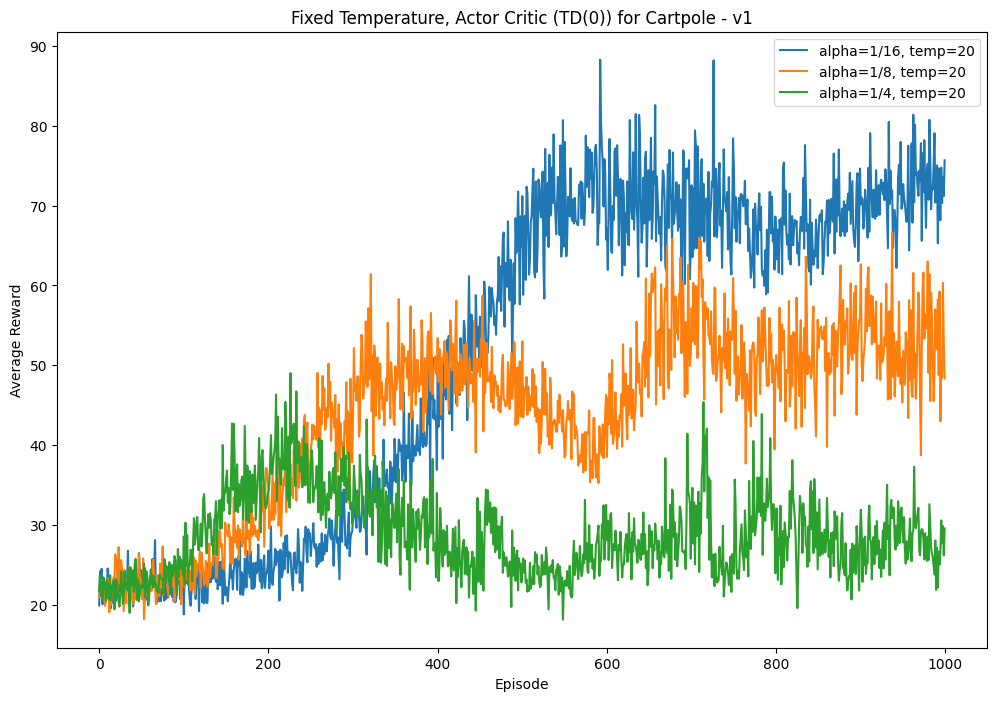

In [45]:
# alpha = 1/8
average_rewards2 = np.mean(return13, axis=0)
average_rewards5 = np.mean(return14, axis=0)
average_rewards8 = np.mean(return15, axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'alpha=1/16, temp=20')
plt.plot(average_rewards5, label=r'alpha=1/8, temp=20')
plt.plot(average_rewards8, label=r'alpha=1/4, temp=20')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Fixed Temperature, Actor Critic (TD(0)) for Cartpole - v1')
plt.legend()

plt.show()

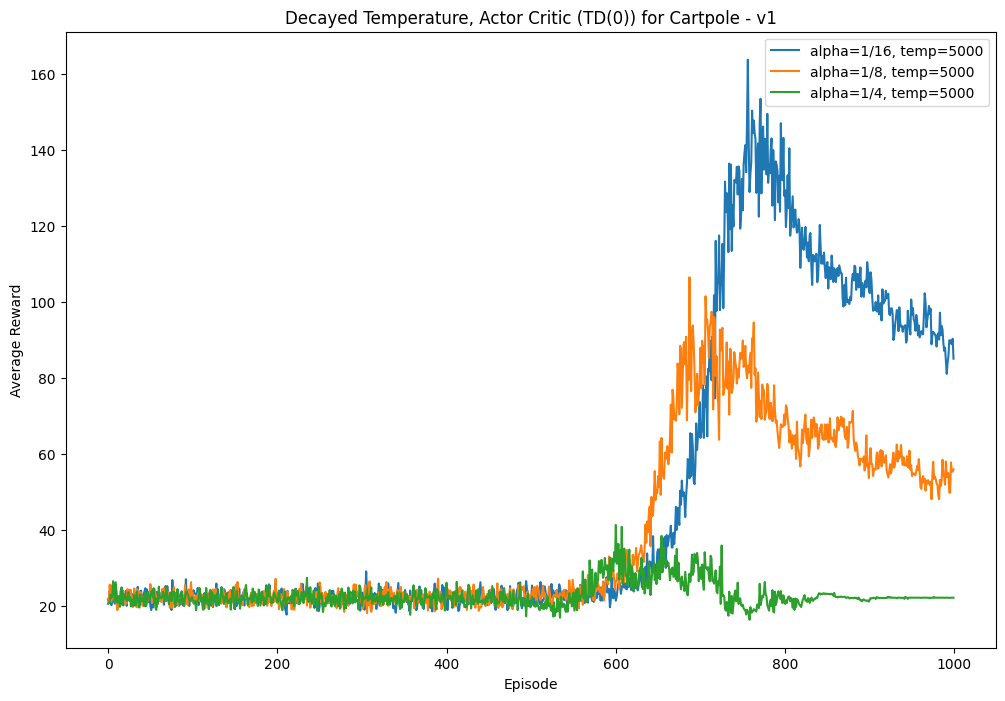

In [47]:
# alpha = 1/8
average_rewards2 = np.mean(return16, axis=0)
average_rewards5 = np.mean(return17, axis=0)
average_rewards8 = np.mean(return18, axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'alpha=1/16, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/8, temp=5000, gamma=0.99')
plt.plot(average_rewards8, label=r'alpha=1/4, temp=5000, gamma=0.99')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Decayed Temperature, Actor Critic (TD(0)) for Cartpole - v1')
plt.legend()

plt.show()

In [97]:
def actor_critic2_mountaincar(alpha, gamma, temp, envi, maximum_step=1000, bin=10, change_temp=False):
    gym.envs.register(
    id="MountainCar-v0",
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=maximum_step,
    #reward_threshold=-110.0,
)
    env = gym.make("MountainCar-v0")
    result = []
    returns = np.zeros((50,1000))
    for run in range(50):
        print("run--", run)
        weights = np.random.uniform(-0.001,0.001,(1,21)) # state-value weights
        theta = np.random.uniform(-0.001,0.001,(1,61)) # policy parameters
        alpha=alpha
        gamma=gamma
        TEMP = temp
        action_space = env.action_space
        for e in range(1000):
            observation, _ = env.reset(seed=run)
            truncated = False
            terminated = False
            I = 1
            if TEMP < 1:
                TEMP = 1
            while not terminated and not truncated:
                action, prob =  softmax_overflow_mountcar(observation, theta, TEMP)
                next_observation, reward, terminated, truncated, info = env.step(action)
                left_theta = policy_encoding_mountcar(observation, 0)
                right_theta = policy_encoding_mountcar(observation, 1)
                mid_theta = policy_encoding_mountcar(observation, 2)
                sum_of_action = prob[0]*left_theta + prob[1]*right_theta + prob[2]*mid_theta
                gradient = 1/TEMP*policy_encoding_mountcar(observation, action) - sum_of_action
                next_value_state = 0 if terminated else np.dot(weights, tile_encoding_mountcar(next_observation))
                current_value_state = np.dot(weights, tile_encoding_mountcar(observation))
                actor_critic_advantage = reward + gamma*next_value_state - current_value_state
                theta += alpha*I*(actor_critic_advantage)*gradient
                weights += alpha*I*(actor_critic_advantage)*tile_encoding_mountcar(observation)
                observation = next_observation
                I = I*gamma
                returns[run, e] -= 1
            if e%200==199:
                print(returns[run, e] + maximum_step)
            if change_temp:
              TEMP*=0.99
    returns += maximum_step
    return returns
#return101 = actor_critic2_mountaincar(1/16, 0.99, 10, 'CartPole-v1',  maximum_step=15000, bin=10,  change_temp=False)
#return102 = actor_critic2_mountaincar(1/4, 0.99, 10, 'CartPole-v1',  maximum_step=15000, bin=10,  change_temp=False)
#return21 = actor_critic2_mountaincar(1/4, 0.99, 20, 'CartPole-v1',  maximum_step=250, bin=10,  change_temp=False)
#return103 = actor_critic2_mountaincar(1/16, 0.99, 5000, 'CartPole-v1',  maximum_step=15000, bin=10,  change_temp=True)
#return104 = actor_critic2_mountaincar(1/4, 0.99, 5000, 'CartPole-v1',  maximum_step=15000, bin=10,  change_temp=True)
#return27 = actor_critic2_mountaincar(1/4, 0.99, 5000, 'CartPole-v1',  maximum_step=200, bin=10,  change_temp=True)
return105 = actor_critic2_mountaincar(1/16, 0.99, 10, 'CartPole-v1',  maximum_step=400, bin=10,  change_temp=False)
#return106 = actor_critic2_mountaincar(1/4, 0.99, 10, 'CartPole-v1',  maximum_step=400, bin=10,  change_temp=False)
#return107 = actor_critic2_mountaincar(1/16, 0.99, 5000, 'CartPole-v1',  maximum_step=400, bin=10,  change_temp=True)
#return108 = actor_critic2_mountaincar(1/4, 0.99, 5000, 'CartPole-v1',  maximum_step=400, bin=10,  change_temp=True)
#return109 = actor_critic2_mountaincar(1/16, 0.99, 10, 'CartPole-v1',  maximum_step=200, bin=10,  change_temp=False)
#return110 = actor_critic2_mountaincar(1/4, 0.99, 10, 'CartPole-v1',  maximum_step=200, bin=10,  change_temp=False)
#return111 = actor_critic2_mountaincar(1/16, 0.99, 5000, 'CartPole-v1',  maximum_step=200, bin=10,  change_temp=True)
#return112 = actor_critic2_mountaincar(1/4, 0.99, 5000, 'CartPole-v1',  maximum_step=200, bin=10,  change_temp=True)

run-- 0
0.0
0.0
0.0
0.0
0.0
run-- 1
0.0
0.0
0.0
0.0
0.0
run-- 2
0.0
0.0
0.0
0.0
0.0
run-- 3
0.0
0.0
0.0
0.0
0.0
run-- 4
0.0
0.0
0.0
0.0
0.0
run-- 5
0.0
0.0
0.0
0.0
0.0
run-- 6
0.0
0.0
0.0
0.0
0.0
run-- 7
0.0
0.0
0.0
0.0
0.0
run-- 8
0.0
0.0
0.0
0.0
0.0
run-- 9
0.0
0.0
0.0
0.0
0.0
run-- 10
0.0
0.0
0.0
0.0
0.0
run-- 11
0.0
0.0
0.0
0.0
0.0
run-- 12
0.0
0.0
0.0
0.0
0.0
run-- 13
0.0
0.0
0.0
0.0
0.0
run-- 14
0.0
0.0
0.0
0.0
0.0
run-- 15
0.0
0.0
0.0
0.0
0.0
run-- 16
0.0
0.0
0.0
0.0
0.0
run-- 17
0.0
0.0
0.0
0.0
0.0
run-- 18
0.0
0.0
0.0
0.0
0.0
run-- 19
0.0
0.0
0.0
0.0
0.0
run-- 20
0.0
0.0
0.0
0.0
0.0
run-- 21
0.0
0.0
0.0
0.0
0.0
run-- 22
0.0
0.0
0.0
0.0
0.0
run-- 23
0.0
0.0
0.0
0.0
0.0
run-- 24
0.0
0.0
0.0
0.0
0.0
run-- 25
0.0
0.0
0.0
0.0
0.0
run-- 26
0.0
0.0
0.0
0.0
0.0
run-- 27
0.0
0.0
0.0
0.0
0.0
run-- 28
0.0
0.0
0.0
0.0
0.0
run-- 29
0.0
0.0
0.0
0.0
0.0
run-- 30
0.0
0.0
0.0
0.0
0.0
run-- 31
0.0
0.0
0.0
0.0
0.0
run-- 32
0.0
0.0
0.0
0.0
0.0
run-- 33
0.0
0.0
0.0
0.0
0.0
run-- 34
0.0
0.0
0.0
0.0

1000


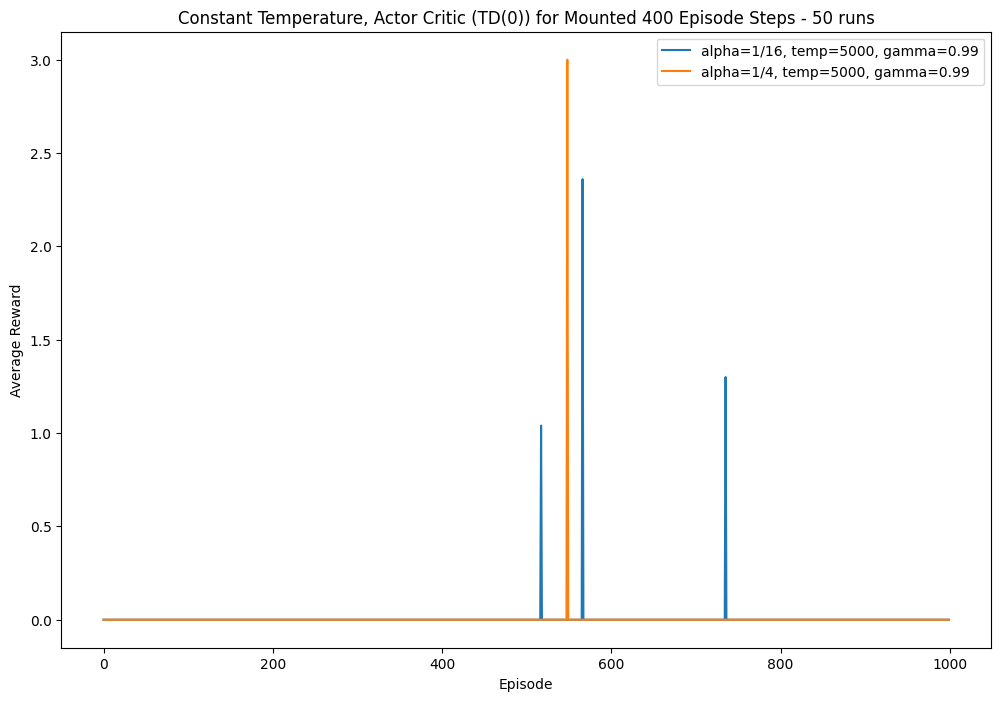

In [104]:
# alpha = 1/8
average_rewards2 = np.mean(return105, axis=0)
average_rewards5 = np.mean(return106, axis=0)
#print(average_rewards2)
#print(average_rewards5)
print(len(average_rewards2))
plt.figure(figsize=(12, 8))
plt.plot(average_rewards2, label=r'alpha=1/16, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/4, temp=5000, gamma=0.99')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Constant Temperature, Actor Critic (TD(0)) for Mounted 400 Episode Steps - 50 runs')
plt.legend()

plt.show()

1000


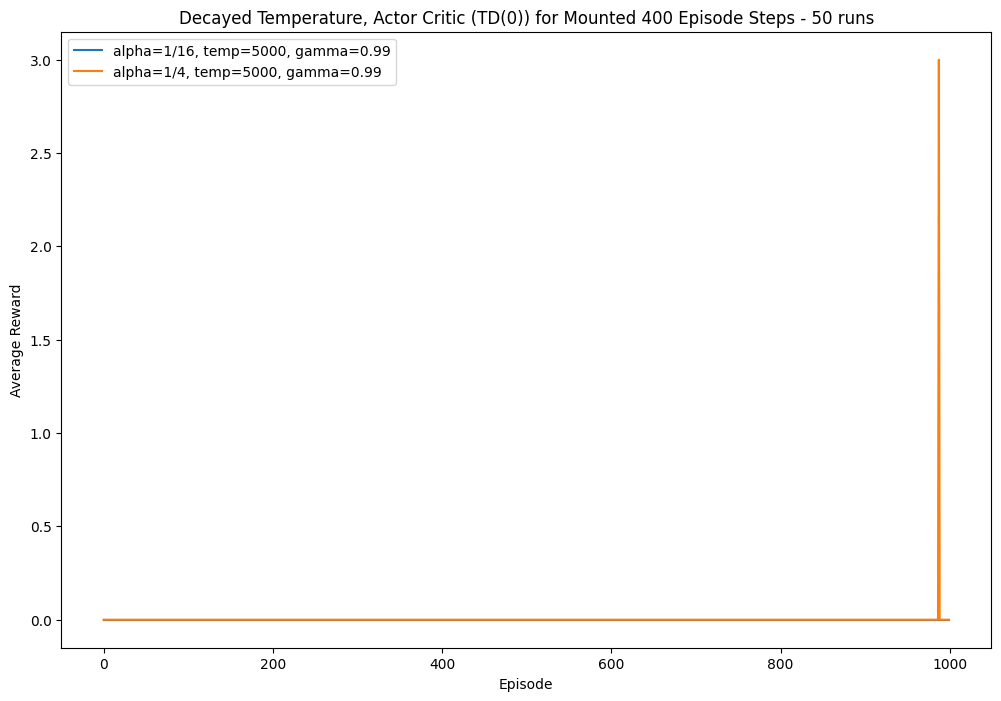

In [107]:
# alpha = 1/8
average_rewards2 = np.mean(return107, axis=0)
average_rewards5 = np.mean(return108, axis=0)
#print(average_rewards2)
#print(average_rewards5)
print(len(average_rewards2))
plt.figure(figsize=(12, 8))
plt.plot(average_rewards2, label=r'alpha=1/16, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/4, temp=5000, gamma=0.99')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Decayed Temperature, Actor Critic (TD(0)) for Mounted 400 Episode Steps - 50 runs')
plt.legend()

plt.show()

[12000.  12000.  12000.  12000.  12000.  12000.  12000.  12000.  13157.2
 12000.  12000.  12265.8 12000.  12000.  12000.  14390.  13810.6 12000.
 12000.  12000.  12000.  12000.  13390.4 13315.2 12000.  13751.4 12000.
 12000.  12233.  12000.  14651.6 12000.  12371.2 14289.2 14082.  14482.
 12000.  12000.  12000.  13810.4 14044.6 14270.6 12000.  13258.8 12666.2
 13707.  14201.6 14424.8 12000.  12000.  12208.6 13871.8 14680.4 14236.
 12000.  14148.8 12000.  13276.4 14051.4 12000.  12000.  13639.  12000.
 12707.6 12774.  12930.2 14494.6 12000.  13212.2 12000.  14334.4 12000.
 12545.4 12878.8 13455.2 13954.8 12000.  14501.  13855.8 12000.  14514.
 12000.  14083.4 14468.2 12000.  12000.  13266.4 13178.6 14394.2 13140.4
 14481.8 13292.  14313.4 12807.2 12000.  12022.2 12100.6 12000.  14738.2
 13130.6 13243.8 12000.  14126.  12794.6 12000.  12070.2 13129.4 14258.8
 14355.8 14210.8 12000.  13658.  14378.  12000.  13734.  12000.  14147.6
 12000.  13899.4 12217.2 14508.4 12000.  14387.2 13204.6 1

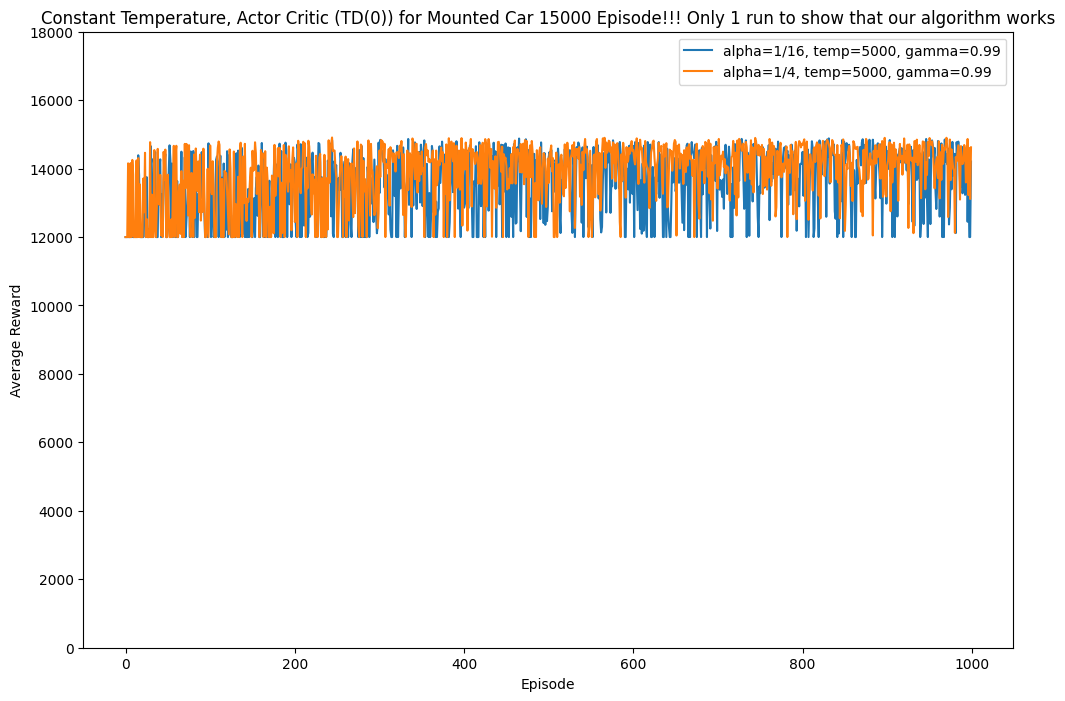

In [92]:
# alpha = 1/8
average_rewards2 = np.mean(return101, axis=0)
average_rewards5 = np.mean(return102, axis=0)
print(average_rewards2)
print(average_rewards5)
plt.figure(figsize=(12, 8))
plt.ylim(0, 18000)
plt.plot(average_rewards2, label=r'alpha=1/16, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/4, temp=5000, gamma=0.99')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Constant Temperature, Actor Critic (TD(0)) for Mounted Car 15000 Episode!!! Only 1 run to show that our algorithm works')
plt.legend()

plt.show()

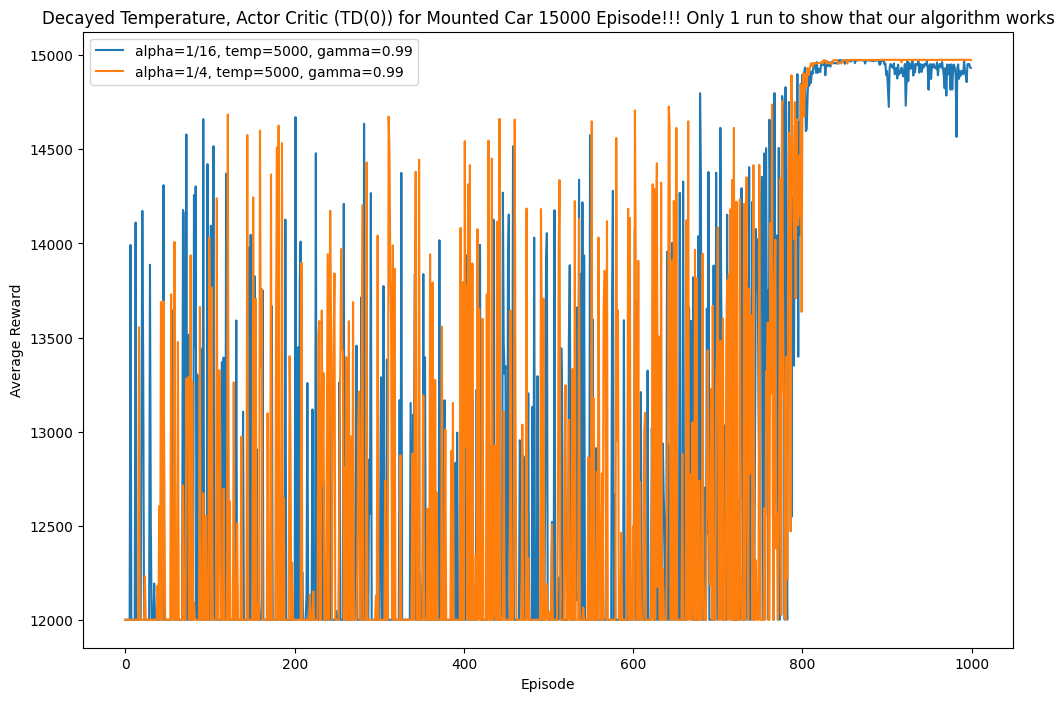

In [86]:
# alpha = 1/8
average_rewards2 = np.mean(return103, axis=0)
average_rewards5 = np.mean(return104, axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'alpha=1/16, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/4, temp=5000, gamma=0.99')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Decayed Temperature, Actor Critic (TD(0)) for Mounted Car 15000 Episode!!! Only 1 run to show that our algorithm works')
plt.legend()

plt.show()

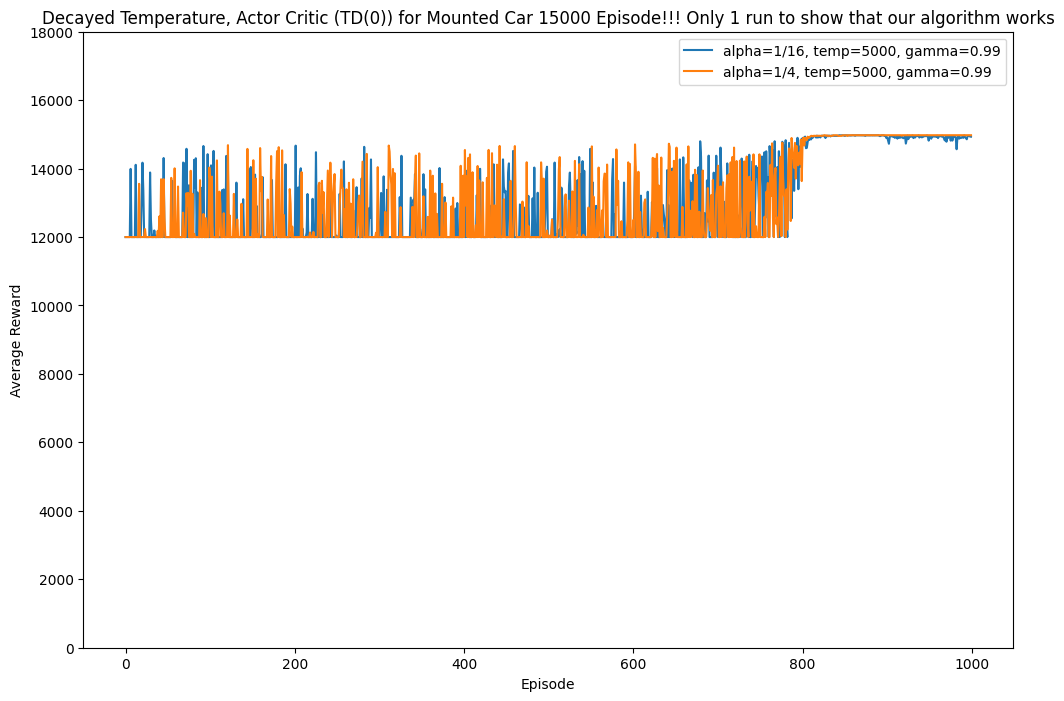

In [93]:
average_rewards2 = np.mean(return103, axis=0)
average_rewards5 = np.mean(return104, axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'alpha=1/16, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/4, temp=5000, gamma=0.99')
plt.ylim(0, 18000)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Decayed Temperature, Actor Critic (TD(0)) for Mounted Car 15000 Episode!!! Only 1 run to show that our algorithm works')
plt.legend()

plt.show()

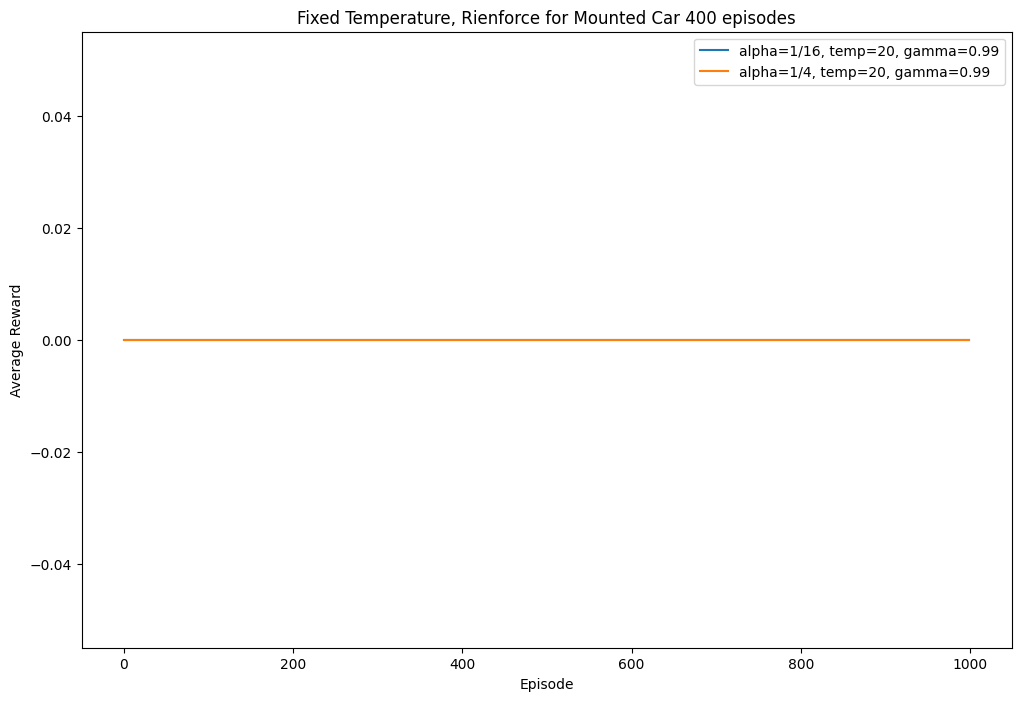

In [122]:
average_rewards2 = np.mean(return4, axis=0)
average_rewards5 = np.mean(return6, axis=0)

plt.figure(figsize=(12, 8))

plt.plot(average_rewards2, label=r'alpha=1/16, temp=20, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/4, temp=20, gamma=0.99')
#plt.ylim(0, 18000)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Fixed Temperature, Rienforce for Mounted Car 400 episodes')
plt.legend()

plt.show()

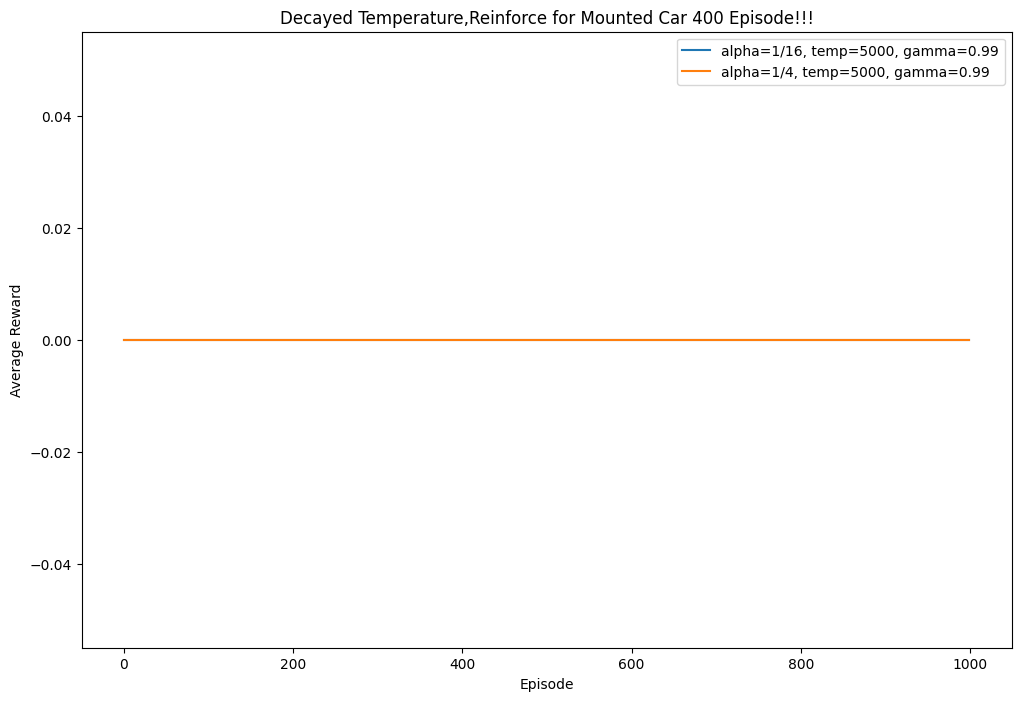

In [124]:
average_rewards4 = np.mean(return1, axis=0)
average_rewards5 = np.mean(return3, axis=0)
plt.figure(figsize=(12, 8))

plt.plot(average_rewards4, label=r'alpha=1/16, temp=5000, gamma=0.99')
plt.plot(average_rewards5, label=r'alpha=1/4, temp=5000, gamma=0.99')
#plt.ylim(0, 18000)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Decayed Temperature,Reinforce for Mounted Car 400 Episode!!!')
plt.legend()

plt.show()

Discussion of the graph. 

ACTOR CRITIC FOR CARPOLE-V1 RESULT DISCUSSION

This discussion explores the application of Actor-Critic methods, specifically 1 step Actor Critic, to the CartPole-V1 environment. We focused on 1 step Actor-Critic because it offers "BIGGEST" variance diff compared to methods like REINFORCE. Our goal was to investigate how the choice of temperature parameter, which influences exploration-exploitation balance, affects learning outcomes.

The results, visualized in two graphs, demonstrate that the decaying temperature strategy achieves higher performance compared to the fixed temperature approach. The decayed temperature allows for exploration early in the training process, leading to a better understanding of the environment's dynamics. This translates to a peak reward exceeding 100, while the fixed temperature approach reaches a maximum reward of around 80. he learning rates tested were α = 1/16, α = 1/8, and α = 1/4, and the temperature parameters were 5000 (decay) and 20 (fixed).

While the decaying temperature approach generally outperforms the fixed temperature, we observe a decrease in reward towards the end of the training process. This can be due to the use of a gamma value (γ) of 0.99. Gamma discounts future rewards, prioritizing immediate rewards over those received later in an episode. In the context of CartPole-V1, where each step is equally important, we assume this discounting mechanism undervalues rewards obtained later in the episode. This underestimation can lead to inaccurate gradient estimations and ultimately lower performance towards the end of training. The fixed temperature approach, by maintaining a constant level of exploration, mitigates this issue to some extent


ACTOR CRITIC FOR MOUNTAIN CAR V0 RESULT DISCUSSION
As discussed in the previous section, The Mountain Car environment presents a unique challenge for reinforcement learning algorithms due to its variable episode lengths. Unlike environments where actions have predictable outcomes, achieving the goal in Mountain Car (escaping the pit) can take a highly variable number of steps. This variability makes it difficult for the agent to learn effectively within a limited timeframe. Our experiment use a maximum episode length of 400 steps and 15000 steps (just one run of 15000 steps to avoid 72 hours computational run time). As the results demonstrate, the graph for 400 steps is absoulutely terrible, only a small number of runs (1-3) were able to successfully exit the pit within this timeframe. This limited success highlights the challenge of short episode lengths in Mountain Car. Without consistent goal achievement, the agent has fewer opportunities to learn and improve its performance.  For 15000 steps, it ensure the car escapes the pit in each training iteration (we have shown in q-learning that it generally require 5000-12000 steps to escape the pit), enabling continuous learning. However, such an increase comes at a computational cost. Running an episode for 15000 steps and 50 runs could take up to 72 hours, making large-scale experimentation impractical, hence we only do 1 run. This single run was super succesful, we could see that the car were able to escape the pit in every episode and update the theta with correct values. We can see from the decayed temeprature graph that, our algorithm actually converge to OPTIMAL VALUE (15000) at the very end within a single run. Constant temperature were also able to reach the optimal award however, it still has the constant variantion due to its temperature.

RIENFORCE FOR CARPOLE-V1 and MOUNTAIN CAR-V0 RESULT DISCUSSION

While REINFORCE can be applied to Mountain Car-v0, its performance often falls short of algorithms like Actor-Critic. This is primarily due to REINFORCE's inherent high variance as discussed in the lecture. This is because reinforce follows Monte Carlo method, it delays the policy update until we finish the episode. As we discussed in the previous section, the Mountain Car-v0, where the agent needs the agent to escape the car pit in order to learn, this approach leads to extremly POOR performance of REINFORCE on mountain car. 
For example, without updates during the episode, REINFORCE might get stuck taking random actions in Mountain Car-v0. This prevents the car from escaping the pit, which is crucial for learning. Unlike REINFORCE, Actor-Critic updates the policy immediately based on every action reward and the estimated value of each state. This allows the agent to learn incrementally throughout the episode and eventually discover actions that lead to escape. As we saw previously, Actor-Critic successfully navigated the car out of the pit within 15,000 steps. In contrast, REINFORCE's lack of in-episode updates resulted in flat zero rewards for both 15,000 and 400-step runs, signifying its inability to learn effectively in this environment.For example, in the case of cartpole problem, the RIENFORCE might make the cartpole keep moving to the right during a run even though it might not be the optimal solutioN. This is because through the 1000 episode of a run, the cartpole has no information on whether the current action is the best one as it only gets delayed award (it gets award when an episode is finished).This limited ability to learn from past successes also contributes to REINFORCE's performance issues. Examining the graph for REINFORCE on CartPole-v1, we observe that the learning rate (alpha) has minimal impact on the reward achieved in the fixed-temperature setting. This suggests that REINFORCE without a baseline function is not effectively learning in this environment as all the alpha have similar shape. In the decayed-temperature setting, the initial explore reward generation during the first few episodes (1-500) due to the high temperature doesn't seem to benefit learning. We see a significant performance drop after the temperature decays. This can again be attributed to the delayed reward nature of REINFORCE and the limited number of successful episodes during training.





